In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys

sys.path.append('/data/yosef2/users/chenling/scVI/')
import scvi
scvi.__version__

import os
os.getcwd()

import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI

from scvi.dataset.anndataset import AnnDatasetFromAnnData
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
tissue = 'exopancreas'
capital_tissue = tissue[0].upper()+tissue[1:]
save_path = '../../AnnotationsRound1/data/'

In [3]:
tenx = read_h5ad(save_path + 'tabula-sapiens-10X-pilot-filtered-%s.h5ad'%tissue)

In [4]:
ss2 = read_h5ad(save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue)

In [5]:
save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue

'../../AnnotationsRound1/data/tabula-sapiens-facs-pilot-filtered-Exopancreas.h5ad'

In [6]:
adata = tenx.concatenate(ss2)

In [7]:
batch = adata.obs['10X_plate'].values.astype(str)

In [8]:
batch_names, adata.obs['batch'] = np.unique(batch,return_inverse=True)

In [9]:
data = AnnDatasetFromAnnData(adata, batch_label='batch')

[2019-12-06 12:24:29,790] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2019-12-06 12:24:30,608] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-06 12:24:30,611] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-06 12:24:30,884] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 12:24:31,164] INFO - scvi.dataset.dataset | Downsampled from 8125 to 8125 cells


In [10]:
data.X.shape

(8125, 21301)

In [11]:
data.subsample_genes(1000)

[2019-12-06 12:24:31,264] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2019-12-06 12:24:39,006] INFO - scvi.dataset.dataset | Downsampling from 21301 to 1000 genes
[2019-12-06 12:24:39,072] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 12:24:39,097] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-06 12:24:39,125] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 12:24:39,137] INFO - scvi.dataset.dataset | Downsampled from 8125 to 8125 cells


In [19]:
n_epochs = 300
save_path = '../data/'
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=False

In [13]:
data.n_batches

4

In [14]:
vae = VAE(data.nb_genes, n_batch=data.n_batches * use_batches,
          n_layers=2, n_latent=10, dispersion='gene')
trainer = UnsupervisedTrainer(
    vae,
    data,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

In [15]:
filename = '%svae.%s10xfacs.pkl'%(save_path,tissue)
print(filename)

../data/vae.exopancreas10xfacs.pkl


In [16]:
retrain

False

In [17]:

if retrain==True:
    torch.manual_seed(0)
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), filename)

else:

    if os.path.isfile(filename):
        trainer.model.load_state_dict(torch.load(filename))
        trainer.model.eval()
    else:
        trainer.train(n_epochs=n_epochs, lr=lr)
        torch.save(trainer.model.state_dict(), filename)

In [20]:
trainer.train(n_epochs=n_epochs, lr=lr)

# code for plotting elbo for training and testing data

(100, 1000)

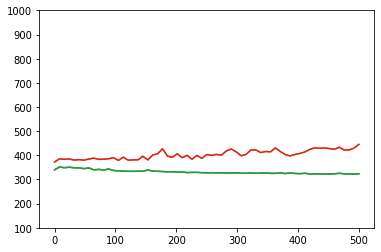

In [21]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(100, 1000)

elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(100, 1000)

In [22]:
posterior = trainer.create_posterior(
        trainer.model, data, indices=np.arange(len(data))
    ).sequential()

latent, _, _ = posterior.get_latent()


# get imputed gene expression values

In [23]:
# imputed_values = posterior.sequential().imputation()
# normalized_values = posterior.sequential().get_sample_scale()

# using scVI latent space in scanpy

In [24]:
adata = tenx.concatenate(ss2)
batch = adata.obs['10X_plate'].values.astype(str)
batch_names, adata.obs['batch'] = np.unique(batch,return_inverse=True)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [25]:
adata.obsm["X_scvi"] = latent
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="X_scvi")
sc.tl.umap(adata)

sc.tl.louvain(adata, key_added="louvain_scvi", resolution=1)

In [26]:
adata.obs.columns

Index(['10X_plate', 'BA_nM', 'NovaSeqRun', 'additional_notes',
       'anatomical_position', 'barcode', 'batch', 'bead_cleanup',
       'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator',
       'lib_prep_date', 'library_prep', 'method', 'n_genes', 'plate',
       'primary_sort', 'sex', 'sort_direction', 'sort_order', 'subjectid',
       'tissue', 'well', 'well_group', 'louvain_scvi'],
      dtype='object')

... storing '10X_plate' as categorical
... storing 'BA_nM' as categorical
... storing 'NovaSeqRun' as categorical
... storing 'additional_notes' as categorical
... storing 'anatomical_position' as categorical
... storing 'barcode' as categorical
... storing 'bead_cleanup' as categorical
... storing 'cDNA_dilute' as categorical
... storing 'cDNA_prep_person' as categorical
... storing 'excluded' as categorical
... storing 'investigator' as categorical
... storing 'lib_prep_date' as categorical
... storing 'library_prep' as categorical
... storing 'method' as categorical
... storing 'plate' as categorical
... storing 'primary_sort' as categorical
... storing 'sex' as categorical
... storing 'sort_direction' as categorical
... storing 'sort_order' as categorical
... storing 'subjectid' as categorical
... storing 'tissue' as categorical
... storing 'well' as categorical
... storing 'well_group' as categorical


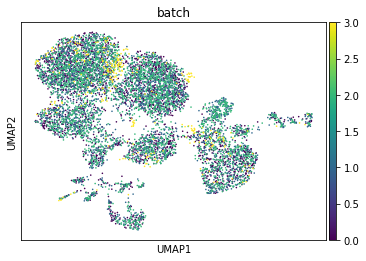

In [27]:
sc.pl.umap(adata, color=['batch'],s=10)

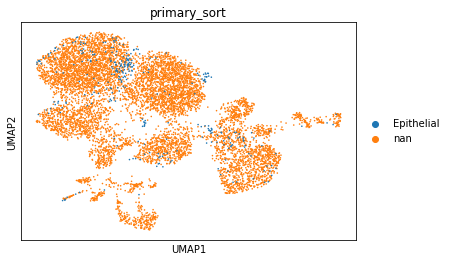

In [64]:
sc.pl.umap(adata, color=['primary_sort'],s=10)

# Epithilium
|Cell type | number | marker genes|
|-----|-----|-------|
|beta|0.08-0.16|INS,NKX6-1,SIX3,MAFA,OLIG1|
|alpha|0.04-0.12|GCG,DPP4,IRX1,IRX2,LOXL4|
|delta|0.01-0.06|SST,HHEX,GHSR,LEPR,POU3F1|
|epsilon|<0.001|ARX,POU6F2|
|gamma/PP|<0.002|ARX,FEV,SERTM1,CNTNAP5,PPY|

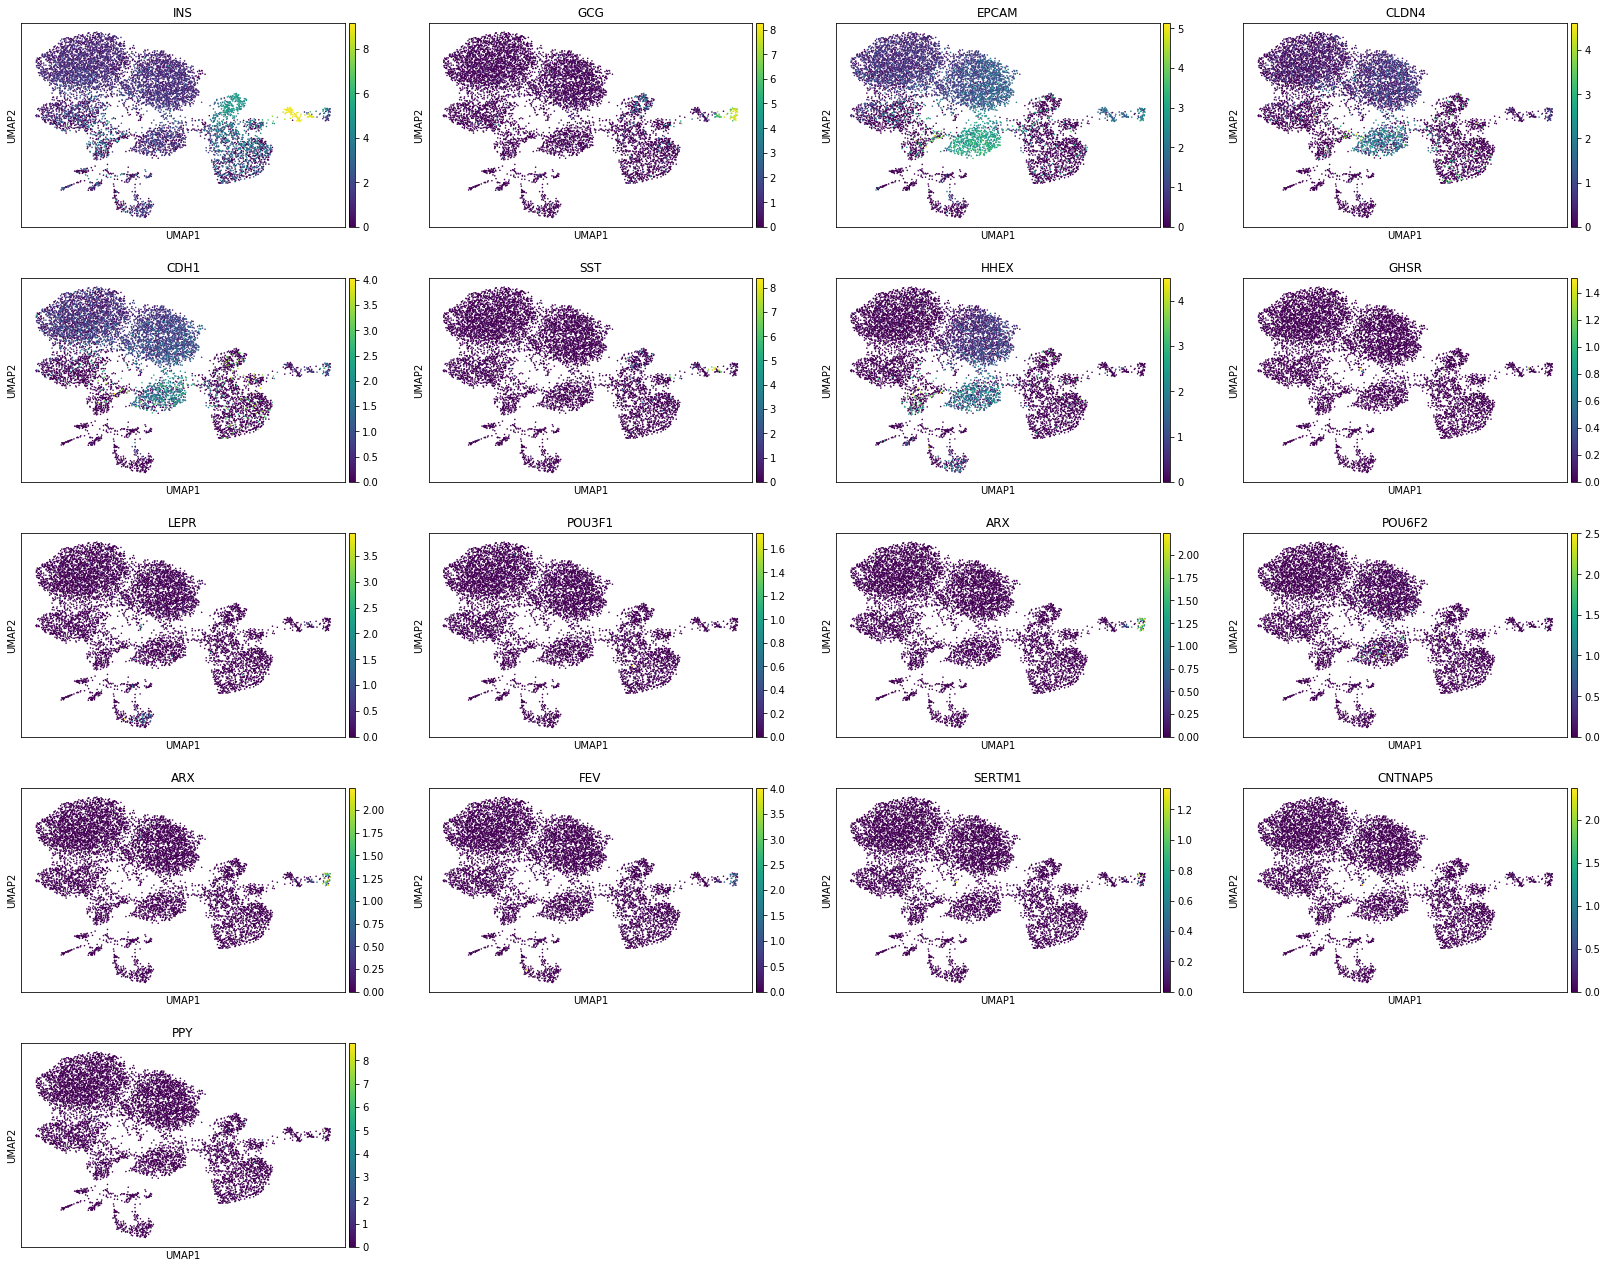

In [30]:
sc.pl.umap(adata, color=['INS','GCG' ,'EPCAM','CLDN4','CDH1',
                         'SST','HHEX','GHSR','LEPR','POU3F1',
                         'ARX','POU6F2','ARX','FEV','SERTM1','CNTNAP5','PPY'],s=10)



# Endothelium	
|Cell type | number | marker genes|
|-----|-----|-------|
|Arteriole	|	|PECAM1,PLVAP,CD40|
|Capilaries	|	|PECAM1,PLVAP|
|Venules	|	|NR2F2,VWF,VCAM1|
|Lymphatic	|	|LYVE1,MMRN1,PDPN,PROX1|

In [31]:
sc.pl.umap(adata, color=['PECAM1','PLVAP','CLDN5'],s=10)

# Stroma	
|Cell type | number | marker genes|
|-----|-----|-------|
|fibroblasts	|		|	PDGFRB,VCAN,RGS5,CSPG4,DES,PDGFRB,SPARC,COL4A1|
|Pericytes	|		|	NKX3-2,GFAP|


In [32]:
sc.pl.umap(adata, color=['COL4A1','GFAP','NKX3-2','COL1A2','DCN','BGN'],s=10)

# PNS
|Cell type | number | marker genes|
|-----|-----|-------|
|SchwannCells|	|SOX10,GDNF,PMP22,CRYAB,SPARC,GFAP,S100B,NCAM1|
|Neuron|	|PGP9.5,TUBB3,TH,SYN1/2,TAC2,SLC18A3|
|Sensory(afferent)|	7% of neuronal|	SP(SubstanceP)|
|Parasympathetic(ganglion,efferent)|	|VAChT(VesicularAcetylcholineTransporter)|
|Sympathetic(efferent)|	|TH(TyrosineHydroxylase)|


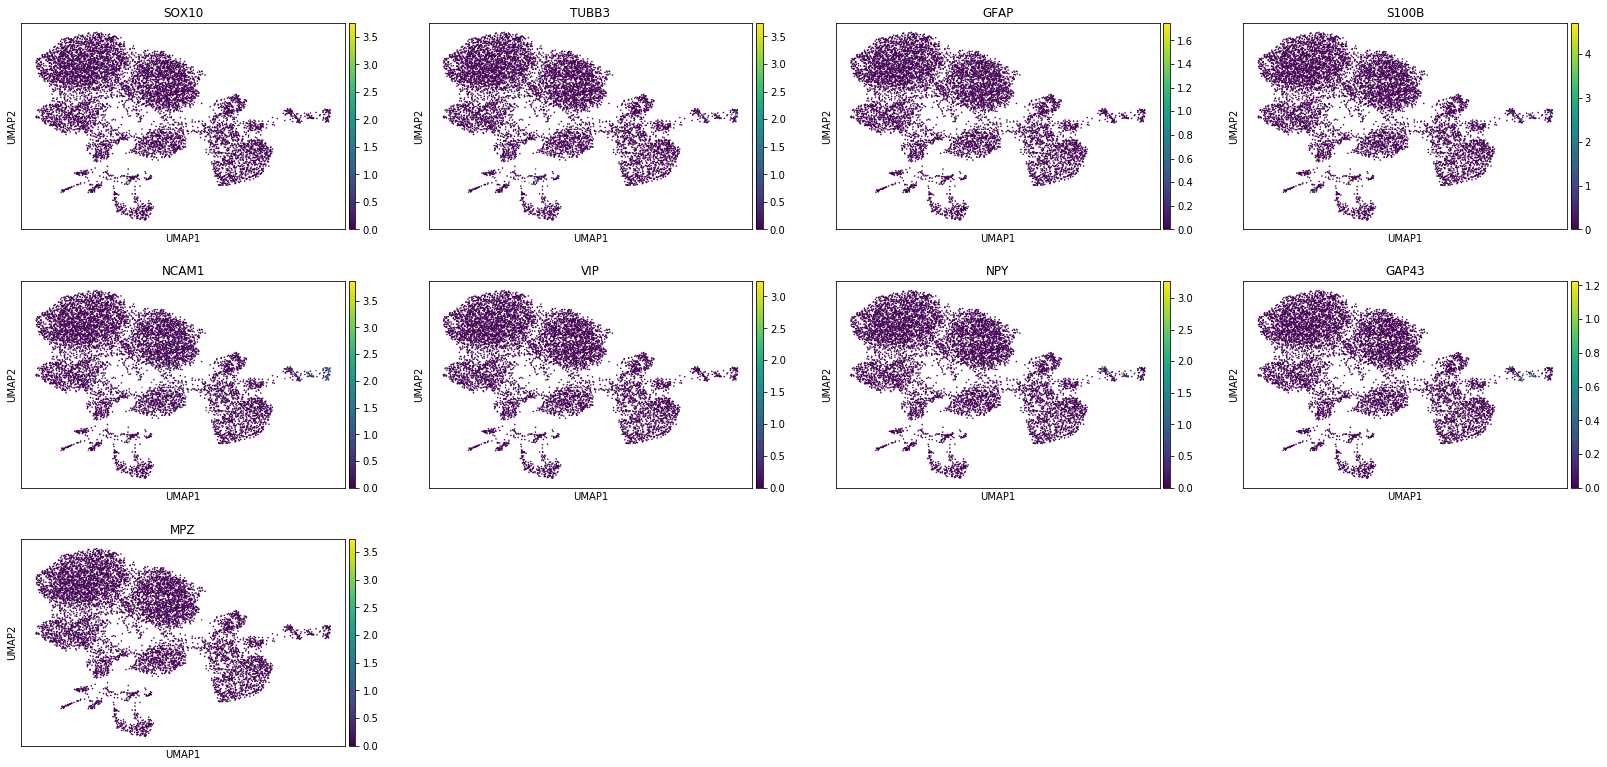

In [33]:
genelist = ['SOX10','TUBB3','GFAP','S100B','NCAM1']+['VIP' ,'NPY','GAP43','MPZ']
sc.pl.umap(adata, color=genelist,s=10)

# immune

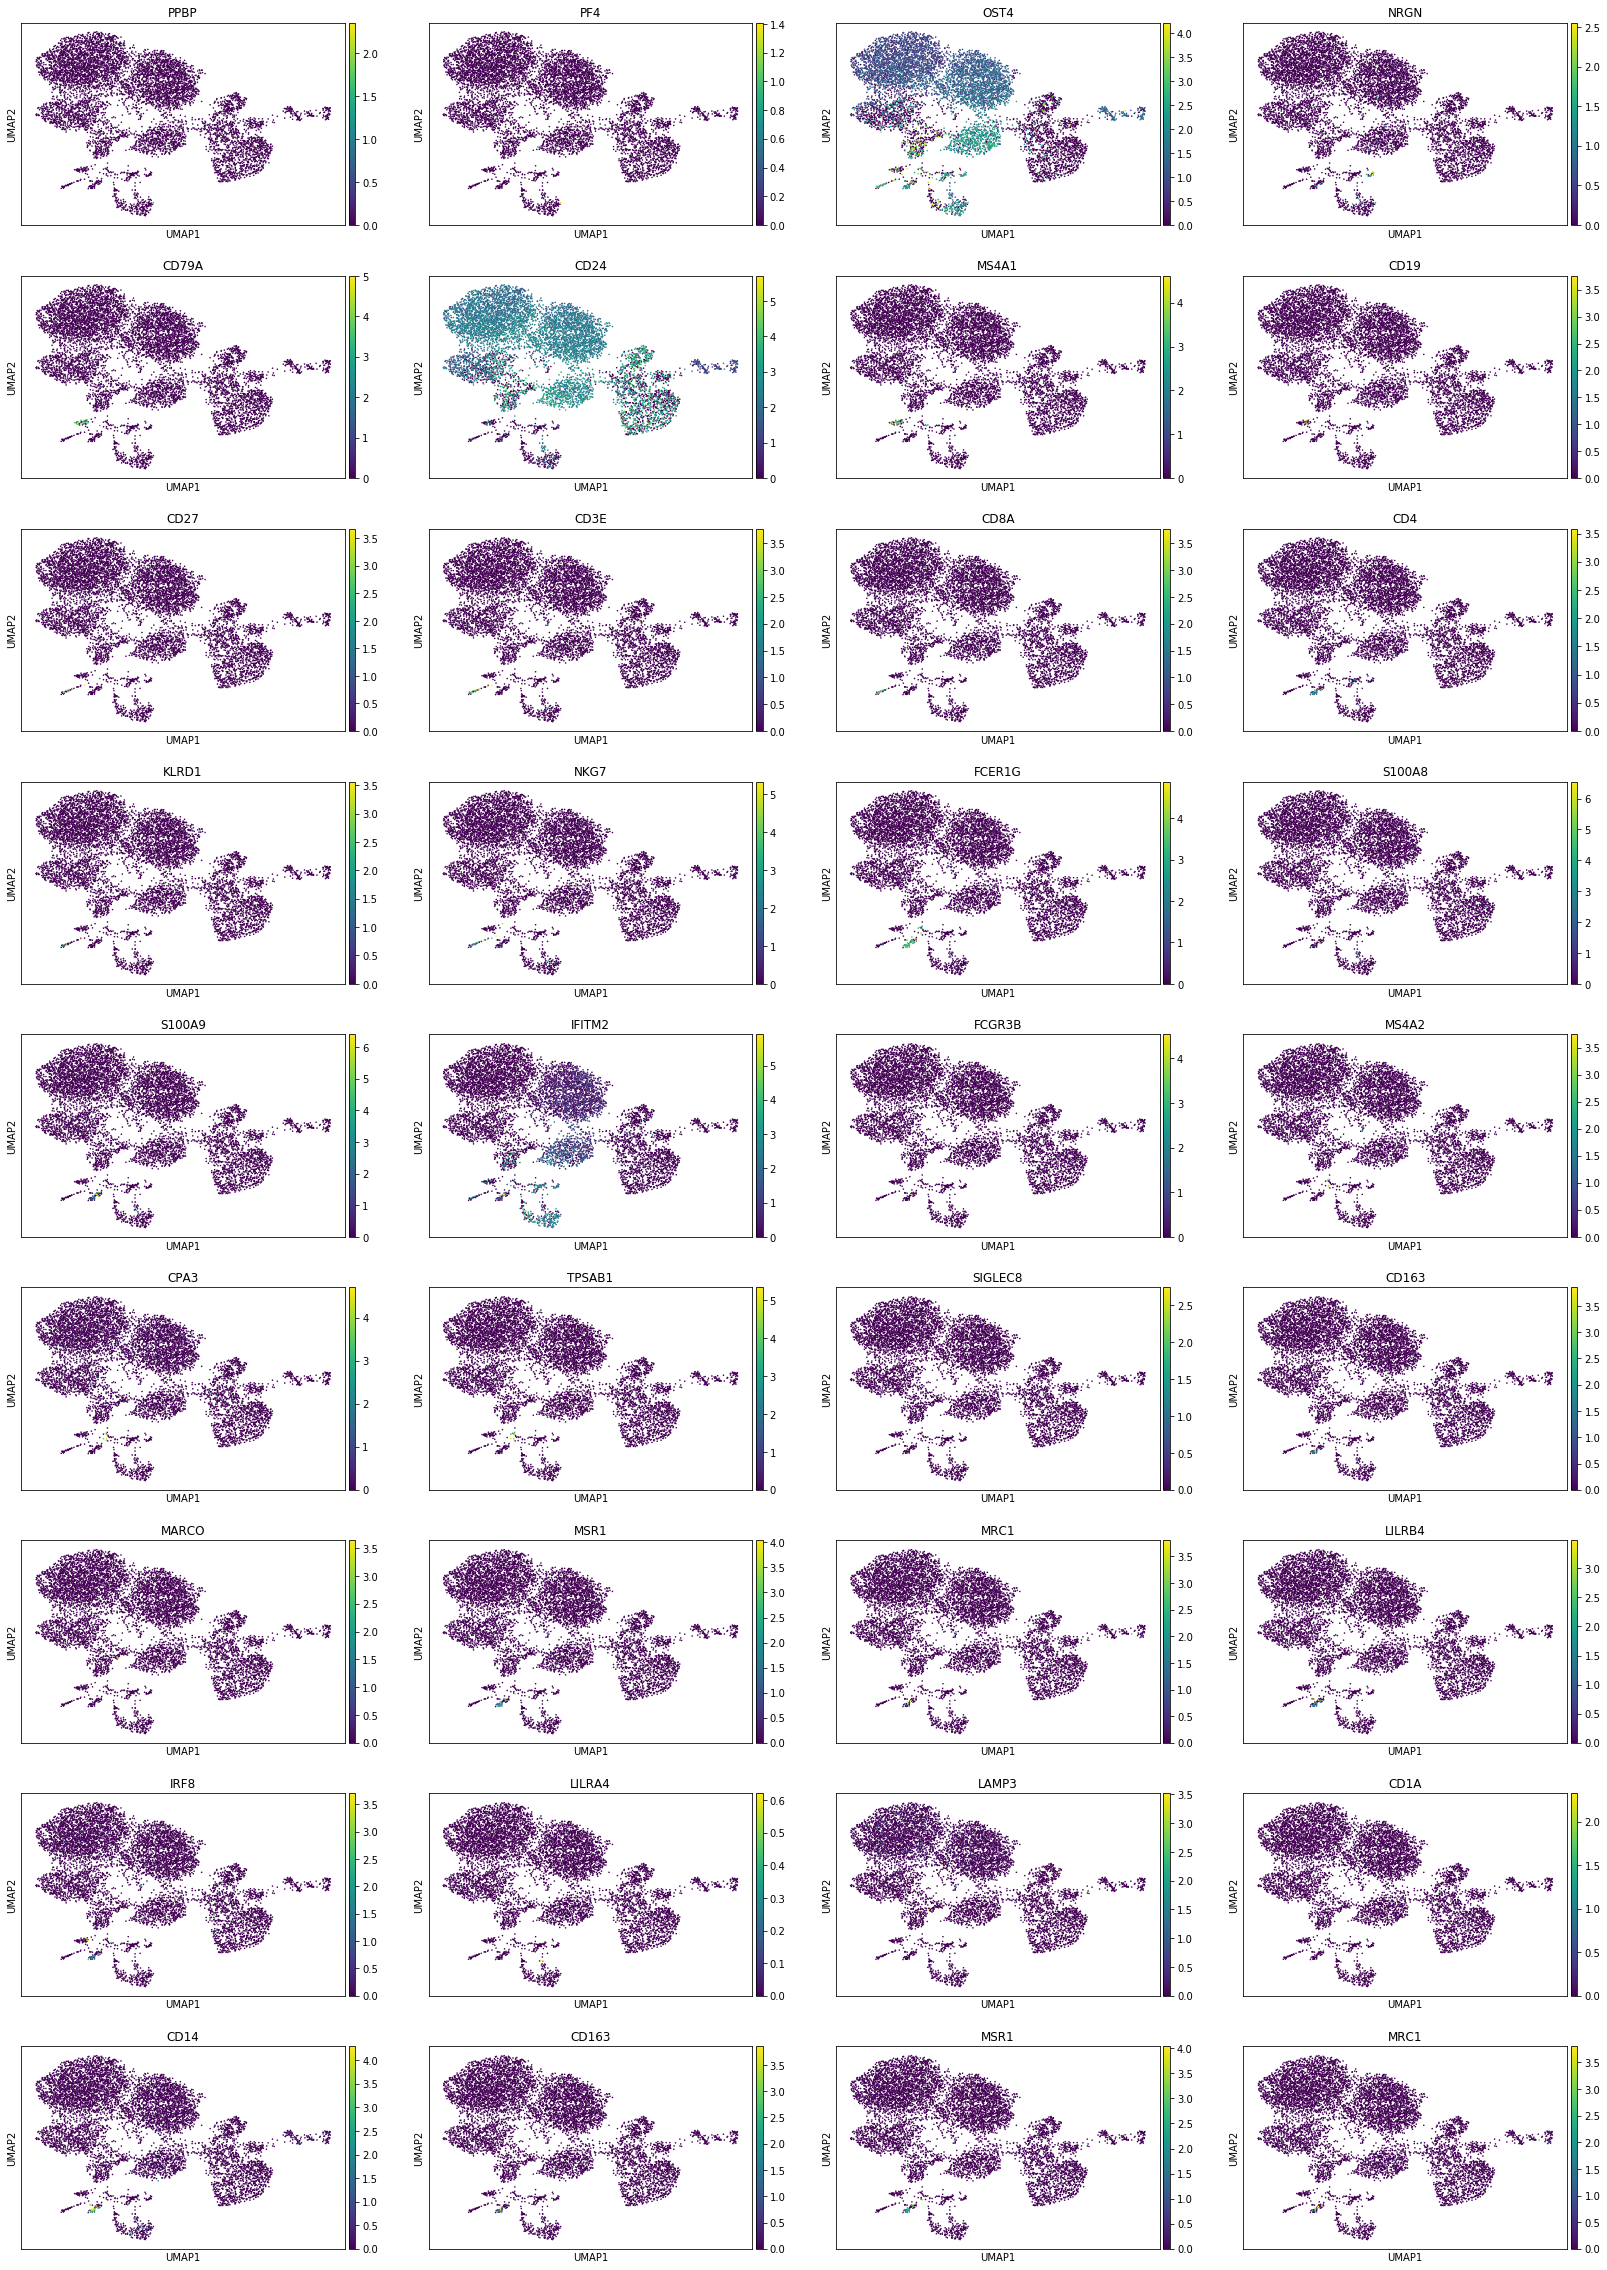

In [34]:
genelist = ['PPBP','PF4','OST4','NRGN',
            'CD79A','CD24','MS4A1','CD19',
           'CD27','CD3E','CD8A','CD4','KLRD1','NKG7','FCER1G',
           'S100A8','S100A9','IFITM2','FCGR3B',
           'MS4A2','CPA3','TPSAB1','SIGLEC8','CD163','MARCO','MSR1','MRC1',
           'LILRB4','IRF8','LILRA4','LAMP3','CD1A','CD14',
           'CD163','MSR1','MRC1']
sc.pl.umap(adata, color=genelist,s=10)

# use scANVI to split compartment, then perform leiden clustering on each compartment

can not be done for exopancreas because the primary sort only contains epithelial? 

# color by predicted compartments

... storing 'compartment_pred' as categorical


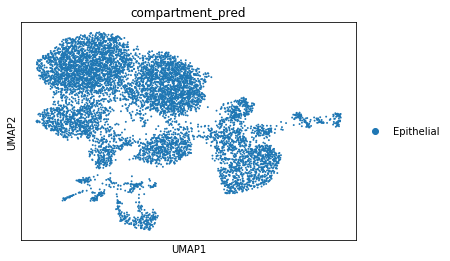

In [43]:
sc.pl.umap(adata, color=['compartment_pred'],palette = 'tab10',ncols=1)

# seed labeling with compartment markers

In [44]:
compartments = {'Epithelial':['INS','GCG' ,'EPCAM','CLDN4','CDH1'], 
                'Endothelial':['PECAM1','CLDN5','CDH5','VWF'],
                'Stromal':['ACTA2' ,'TAGLN','DCN','PDGFRA'],
               'Immune':['PTPRC','RAC2','LCP1']}

In [45]:
for x in compartments.keys():
    sc.tl.score_genes(adata, ctrl_size=100, gene_list=compartments[x],score_name = x)

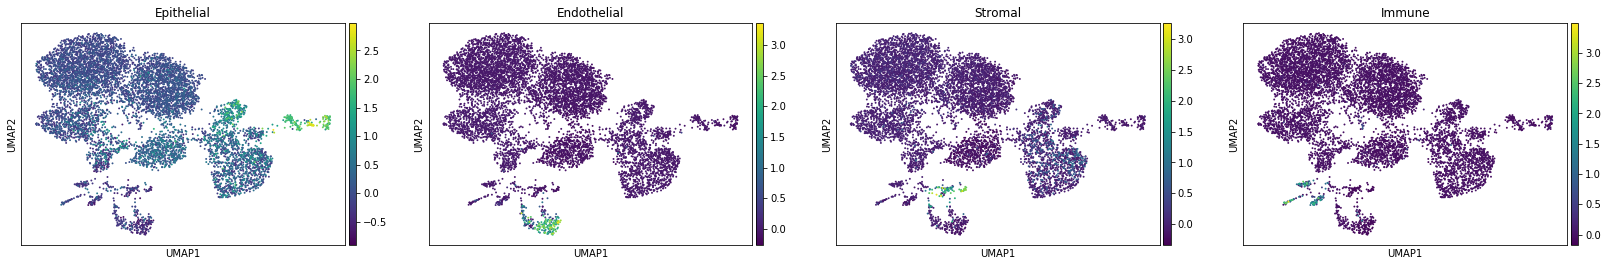

In [46]:
sc.pl.umap(adata, color=compartments.keys())

In [65]:
for x in compartments.keys():
    indicator = x+'_label'
    # compute gene signature scores
    sc.tl.score_genes(adata, compartments[x], score_name=x)
    cutoff = np.min(adata.obs.nlargest(100,x)[x].values)
    if x=='Epithelial':
        cutoff = np.min(adata.obs.nlargest(1000,x)[x].values)
    adata.obs[indicator] = (adata.obs[x].values>cutoff).astype(str)


... storing 'Epithelial_label' as categorical
... storing 'Endothelial_label' as categorical
... storing 'Stromal_label' as categorical
... storing 'Immune_label' as categorical


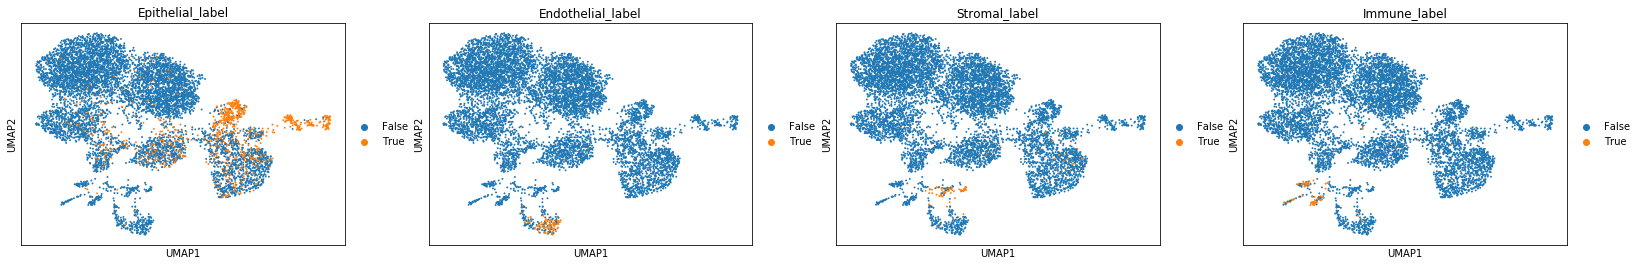

In [66]:
labelled = [x+'_label' for x in compartments.keys()]
sc.pl.umap(adata, color=labelled)

In [67]:
all_indicators = pd.concat([adata.obs[x+'_label'] for x in compartments.keys()], axis = 1)
unique_celltypes = ((all_indicators.values=='True').sum(axis=1) <=1 )

labels = np.repeat(0, data.X.shape[0])
for i, c in enumerate(compartments.keys()):
    idx = np.where(
        np.logical_and(
        unique_celltypes, 
        adata.obs[c+'_label'].values=='True'))[0]
    labels[idx] = i+1

data.cell_types = ['unlabelled']+list(compartments.keys())
data.labels = labels.reshape(len(labels),1)
data.n_labels = len(data.cell_types)

labelled = np.where(data.labels.ravel()!=0)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)

unlabelled = np.where(data.labels.ravel()==0)[0]
unlabelled = np.random.choice(unlabelled, len(unlabelled), replace=False)


In [68]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([6851,  990,   97,   90,   97]))

In [69]:

labels_pred = []
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=10, symmetric_kl=True)
filename = '%s/vae.%s10xfacs.pkl'%(save_path,tissue)
scanvi.load_state_dict(torch.load(filename), strict=False)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, data, n_epochs_classifier=50, lr_classification=5 * 1e-3)

trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled)
trainer_scanvi.train(n_epochs=15)
full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, pred = full.sequential().compute_predictions()

... storing 'comp_pred' as categorical


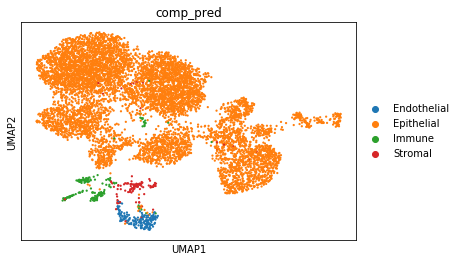

In [70]:
adata.obs['comp_pred'] = [data.cell_types[i] for i in pred]
sc.pl.umap(adata, color=['comp_pred'],  show=show_plot,size=20)

# plotting cell cycle changes

In [72]:
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [73]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


... storing 'phase' as categorical


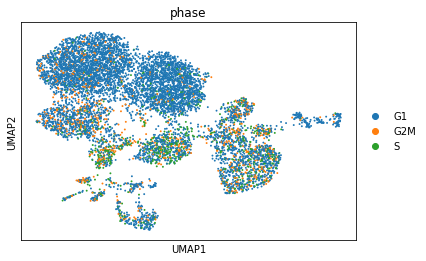

In [56]:
sc.pl.umap(adata,color=['phase'])

# differential expression

... storing 'phase' as categorical


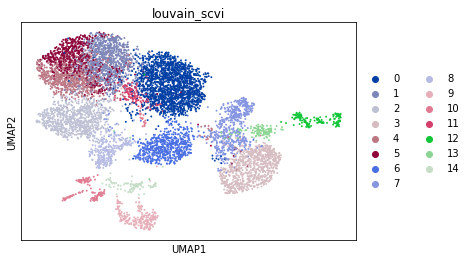

In [74]:
sc.pl.umap(adata, color=['louvain_scvi'],ncols=1)

In [75]:
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=adata.shape[1],
)

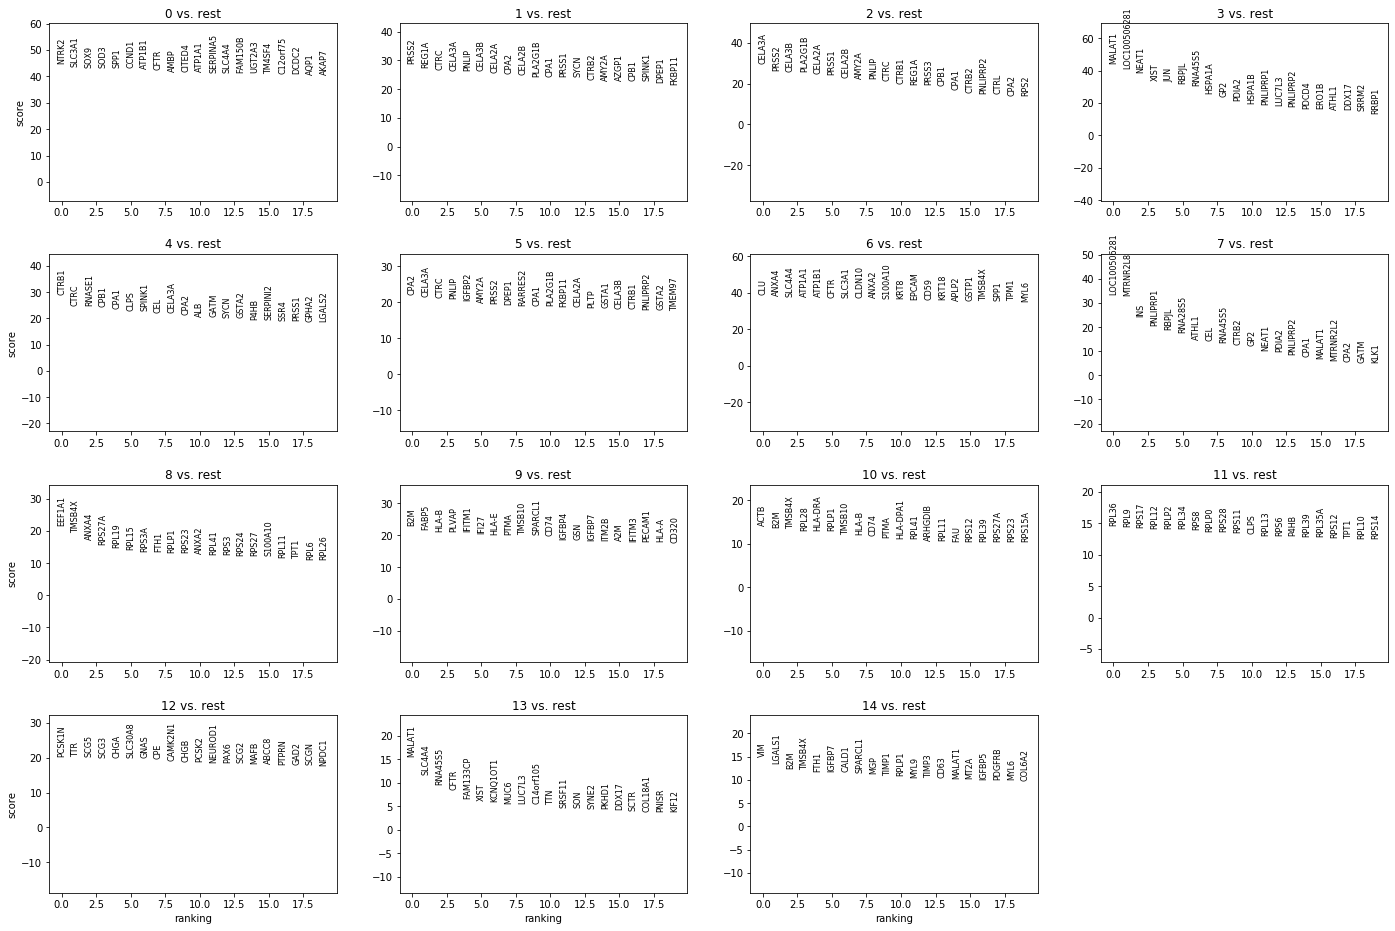

In [76]:
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False
)

In [77]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
result = adata.uns['rank_genes_groups_wilcox']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('%s.wilcoxon.csv'%tissue)

In [78]:
sapiens_rank_genes_scores

0_n        0_s            0_p           1_n        1_s            1_p            2_n        2_s            2_p                     3_n        3_s            3_p          4_n        4_s            4_p           5_n        5_s            5_p           6_n        6_s            6_p              7_n        7_s            7_p           8_n        8_s            8_p           9_n        9_s            9_p          10_n       10_s          10_p          11_n       11_s          11_p          12_n       12_s          12_p          13_n       13_s          13_p          14_n       14_s          14_p
0             NTRK2  44.693764   0.000000e+00         PRSS2  28.734299  1.423140e-181         CELA3A  29.651075  3.285038e-193                  MALAT1  44.086227   0.000000e+00        CTRB1  28.997730  7.027837e-185          CPA2  22.035803  1.307060e-107           CLU  39.009499   0.000000e+00     LOC100506281  33.418526  7.378578e-245        EEF1A1  21.686455  2.754123e-104           B2M  23.067017  9.927742e-118          ACTB  14.161482  1.586130e-45         RPL36  14.647709  1.393345e-48        PCSK1N  20.423380  1.036410e-92        MALAT1  15.650229  3.310225e-55           VIM  15.063169  2.828964e-51
1            SLC3A1  43.848431   0.000000e+00         REG1A  27.500999  1.707937e-166          PRSS2  26.584753  1.018800e-155            LOC100506281  41.400372   0.000000e+00         CTRC  24.852612  2.423124e-136        CELA3A  21.547157  5.629912e-103         ANXA4  38.834858   0.000000e+00         MTRNR2L8  33.003078  7.336840e-239        TMSB4X  19.607067   1.345694e-85         FABP5  21.760353  5.512264e-105           B2M  13.690750  1.153123e-42          RPL9  14.412765  4.301423e-47           TTR  20.395687  1.826324e-92        SLC4A4  11.761515  6.161851e-32        LGALS1  13.479815  2.056232e-41
2              SOX9  43.395996   0.000000e+00          CTRC  26.700237  4.676991e-157         CELA3B  26.158026  7.986739e-151                   NEAT1  39.016537   0.000000e+00       RNASE1  24.787216  1.231437e-135          CTRC  21.378374  2.124044e-101        SLC4A4  38.126598   0.000000e+00              INS  24.528271  7.378055e-133         ANXA4  17.425215   5.310929e-68         HLA-B  21.273630  1.992455e-100        TMSB4X  13.416415  4.845941e-41         RPS17  14.363622  8.753080e-47          SCG5  20.313688  9.731608e-92       RNA45S5   9.698378  3.063304e-22           B2M  12.480984  9.480766e-36
3              SOD3  43.332325   0.000000e+00        CELA3A  26.314121  1.321949e-152        PLA2G1B  25.791555  1.102893e-146                    XIST  33.943813  1.505159e-252         CPB1  24.538809  5.694631e-133         PNLIP  21.000387   6.505198e-98        ATP1A1  38.082573   0.000000e+00         PNLIPRP1  20.704206   3.174234e-95        RPS27A  15.663476   2.687957e-55         PLVAP  21.154999   2.481909e-99         RPL28  12.997728  1.260322e-38         RPL12  14.221021  6.785580e-46          SCG3  20.167887  1.874827e-90          CFTR   8.578768  9.589464e-18        TMSB4X  12.133583  7.011302e-34
4              SPP1  43.279198   0.000000e+00         PNLIP  26.313597  1.340344e-152         CELA2A  24.760757  2.374418e-135                     JUN  33.014603  5.013603e-239         CPA1  23.675953  6.379876e-124        IGFBP2  20.327997   7.270917e-92        ATP1B1  38.065548   0.000000e+00            RBPJL  18.910671   9.316181e-80         RPL19  14.946617   1.638647e-50        IFITM1  21.056831   1.979810e-98       HLA-DRA  12.973821  1.722270e-38         RPLP2  14.178474  1.245250e-45          CHGA  20.133633  3.745053e-90      FAM133CP   6.613124  3.762933e-11          FTH1  11.878512  1.530669e-32
5             CCND1  43.273056   0.000000e+00        CELA3B  26.303488  1.749418e-152          PRSS1  24.512417  1.089067e-132                   RBPJL  31.859833  9.620403e-223         CLPS  23.148750  1.496496e-118         AMY2A  19.872078   7.100219e-88          CFTR  37.500130  9.165545e-308          RNA28S5  17.566900   4.4165

In [79]:
adata.write('%s.scVI.h5ad'%tissue)